# Distribuciones de Extinción y Muestreo Cosmológico en Simulaciones de Supernovas

Este notebook explica los métodos implementados para generar distribuciones realistas de extinción (Vía Láctea y galaxias huésped) y el muestreo de volumen cosmológico en función del redshift para las simulaciones de detectabilidad de supernovas.

## Motivación Científica

En estudios de detectabilidad de supernovas, es fundamental modelar correctamente:

1. **Extinción de la Vía Láctea (MW)**: Varía según la línea de visión y afecta todas las observaciones
2. **Extinción del huésped**: Depende del tipo de supernova y la galaxia huésped
3. **Volumen cosmológico**: El muestreo debe ser proporcional al volumen observable

## Objetivos

- Implementar modelos físicamente motivados para extinción MW y huésped
- Derivar y aplicar el muestreo correcto de volumen cosmológico
- Validar las distribuciones contra observaciones reales

In [21]:
from astroquery.irsa_dust import IrsaDust
from astropy.coordinates import SkyCoord
import astropy.units as u

# Coordenadas de ejemplo (RA, Dec en grados)
coord = SkyCoord(ra=210.8023*u.deg, dec=54.3489*u.deg, frame='icrs')

# Consulta al servicio
table = IrsaDust.get_query_table(coord, section='ebv')

# Muestra los resultados
table


ext desc,ext image,ext table,ext SandF ref,ext SandF ref RA,ext SandF ref Dec,ext SandF ref coord sys,ext SandF mean,ext SandF std,ext SandF max,ext SandF min,ext SFD ref,ext SFD ref RA,ext SFD ref Dec,ext SFD ref coord sys,ext SFD mean,ext SFD std,ext SFD max,ext SFD min
,,,,deg,deg,,,,,,,deg,deg,,,,,
bytes100,bytes255,bytes255,float64,float64,float64,bytes25,float64,float64,float64,float64,float64,float64,float64,bytes25,float64,float64,float64,float64
E(B-V) Reddening,https://irsa.ipac.caltech.edu:443//workspace/TMP_ZDTAaQ_31421/DUST/210.80229793699863_54.34890065944222.v0001/p379Dust.fits,https://irsa.ipac.caltech.edu:443//workspace/TMP_ZDTAaQ_31421/DUST/210.80229793699863_54.34890065944222.v0001/extinction.tbl,0.0074,210.8023,54.3489,equ J2000,0.0074,0.0001,0.0076,0.0073,0.0086,210.8023,54.3489,equ J2000,0.0086,0.0001,0.0089,0.0085


In [22]:
float(table['ext SandF mean'])

0.0074

In [23]:
from astroquery.alerce import Alerce

client = Alerce(token='TU_TOKEN')

# Consulta por nombre
name = "ZTF19acgjnjm"
object_data = client.query_by_name(name)

ra = object_data['ra']
dec = object_data['dec']
print(f"RA: {ra}, Dec: {dec}")


ModuleNotFoundError: No module named 'astroquery.alerce'

In [24]:
# Importar librerías necesarias
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.integrate import quad
from scipy.optimize import curve_fit
import pandas as pd

# Configuración de plots
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

# Constantes cosmológicas (Planck 2018)
H0 = 70.0  # km/s/Mpc
Omega_m = 0.315
Omega_Lambda = 0.685
c = 299792.458  # km/s

print("Librerías importadas correctamente")
print(f"Parámetros cosmológicos: H0={H0} km/s/Mpc, Ωm={Omega_m}, ΩΛ={Omega_Lambda}")

Librerías importadas correctamente
Parámetros cosmológicos: H0=70.0 km/s/Mpc, Ωm=0.315, ΩΛ=0.685


# 1. Extinción de la Vía Láctea

## Marco Teórico

La extinción de la Vía Láctea sigue el modelo de **Schlegel, Finkbeiner & Davis (1998)** basado en mapas de polvo infrarrojo. La extinción total viene dada por:

$$A_V = R_V \cdot E(B-V)$$

donde:
- $R_V = 3.1$ (razón total a selectiva estándar)
- $E(B-V)$ es el enrojecimiento color

## Dependencia con Latitud Galáctica

La extinción varía sistemáticamente con la latitud galáctica $b$:

$$E(B-V) \propto \sec|b| \cdot f(l, d)$$

donde:
- $l$ es la longitud galáctica
- $d$ es la distancia
- $f(l,d)$ incluye estructura del disco y brazos espirales

## Implementación REAL para ZTF

Para obtener valores reales de extinción MW, consultamos directamente el servicio IRSA Dust que proporciona acceso a los mapas SFD98:

1. **Consulta directa a IRSA**: Usando `astroquery.irsa_dust.IrsaDust`
2. **Coordenadas realistas del footprint ZTF**: Muestreo uniforme en el área observable  
3. **Valores E(B-V) reales**: Directamente de los mapas SFD98 sin aproximaciones

**Ventajas:**
- ✅ Valores exactos de los mapas originales SFD98
- ✅ No requiere descargar archivos FITS (consulta online)
- ✅ Manejo automático de errores de conexión

**Limitaciones:**
- ⏱️ Requiere conexión a internet
- ⏱️ Consultas pueden ser lentas (5000 consultas ≈ 2-3 minutos)
- 🌐 Dependiente del servicio IRSA

In [35]:
def sample_ztf_field_coordinates(n_samples=1000, random_state=42):
    """
    Muestrea coordenadas realistas de campos ZTF
    
    ZTF opera principalmente en:
    - RA: 0-360° (distribución uniforme)
    - Dec: -30° a +70° (footprint observable)
    - Evita plano galáctico (|b| > 10°)
    """
    np.random.seed(random_state)
    
    # RA uniforme
    ra_samples = np.random.uniform(0, 360, n_samples)
    
    # Dec concentrado en footprint ZTF
    dec_samples = np.random.uniform(-30, 70, n_samples)
    
    return ra_samples, dec_samples

def get_sfd98_extinction_real(ra, dec):
    """
    Consulta REAL a los mapas SFD98 usando IRSA Dust Service
    
    Parameters:
    -----------
    ra : float
        Ascensión recta en grados
    dec : float
        Declinación en grados
    
    Returns:
    --------
    float
        E(B-V) de extinción MW según SFD98
    """
    from astroquery.irsa_dust import IrsaDust
    from astropy.coordinates import SkyCoord
    import astropy.units as u
    
    try:
        # Crear coordenada
        coord = SkyCoord(ra=ra*u.deg, dec=dec*u.deg, frame='icrs')
        
        # Consulta al servicio IRSA
        table = IrsaDust.get_query_table(coord, section='ebv')
        
        # Extraer E(B-V) de SFD98
        ebv_mw = float(table['ext SandF mean'])
        #print(f"Consulta exitosa: RA={ra:.3f}, Dec={dec:.3f} → E(B-V)={ebv_mw:.3f} mag")
        
        return ebv_mw
        
    except Exception as e:
        # En caso de error de conexión, usar valor promedio
        print(f"Warning: Error consultando IRSA para RA={ra:.3f}, Dec={dec:.3f}: {e}")
        print("Usando valor promedio E(B-V)=0.05 mag")
        return 0.05

# Generar muestra de extinción MW REAL usando mapas SFD98
print("Generando muestra de extinción MW con consultas REALES a SFD98...")
print("⚠️  Esto puede tomar unos minutos debido a las consultas online...")

n_samples = 5000
ra_coords, dec_coords = sample_ztf_field_coordinates(n_samples)

ebmv_mw_samples = []  # Lista vacía, NO array numpy
failed_queries = 0

# Procesar en lotes para mostrar progreso
batch_size = 100
for batch_start in range(0, n_samples, batch_size):
    batch_end = min(batch_start + batch_size, n_samples)
    print(f"Procesando coordenadas {batch_start+1}-{batch_end} de {n_samples}...")
    
    for i in range(batch_start, batch_end):
        ebmv_mw = get_sfd98_extinction_real(ra_coords[i], dec_coords[i])
        ebmv_mw_samples.append(ebmv_mw)
        
        # Contador de errores
        if ebmv_mw == 0.05:  # Valor por defecto en caso de error
            failed_queries += 1

ebmv_mw_samples = np.array(ebmv_mw_samples)

print(f"\n✅ Muestra generada: {len(ebmv_mw_samples)} campos")
print(f"📊 Consultas exitosas: {n_samples - failed_queries}/{n_samples} ({100*(n_samples-failed_queries)/n_samples:.1f}%)")
if failed_queries > 0:
    print(f"⚠️  Consultas fallidas: {failed_queries} (usaron valor por defecto)")

print(f"\n📈 Estadísticas de extinción MW REAL:")
print(f"E(B-V)_MW - Media: {np.mean(ebmv_mw_samples):.3f}")
print(f"E(B-V)_MW - Mediana: {np.median(ebmv_mw_samples):.3f}")
print(f"E(B-V)_MW - Rango: {np.min(ebmv_mw_samples):.3f} - {np.max(ebmv_mw_samples):.3f}")
print(f"E(B-V)_MW - Desv. std: {np.std(ebmv_mw_samples):.3f}")

Generando muestra de extinción MW con consultas REALES a SFD98...
⚠️  Esto puede tomar unos minutos debido a las consultas online...
Procesando coordenadas 1-100 de 5000...
Procesando coordenadas 101-200 de 5000...
Procesando coordenadas 101-200 de 5000...
Procesando coordenadas 201-300 de 5000...
Procesando coordenadas 201-300 de 5000...
Procesando coordenadas 301-400 de 5000...
Procesando coordenadas 301-400 de 5000...
Procesando coordenadas 401-500 de 5000...
Procesando coordenadas 401-500 de 5000...
Procesando coordenadas 501-600 de 5000...
Procesando coordenadas 501-600 de 5000...
Procesando coordenadas 601-700 de 5000...
Procesando coordenadas 601-700 de 5000...
Procesando coordenadas 701-800 de 5000...
Procesando coordenadas 701-800 de 5000...
Procesando coordenadas 801-900 de 5000...
Procesando coordenadas 801-900 de 5000...
Procesando coordenadas 901-1000 de 5000...
Procesando coordenadas 901-1000 de 5000...
Usando valor promedio E(B-V)=0.05 mag
Usando valor promedio E(B-V)=0.

# 2. Extinción de la Galaxia Huésped

## Marco Teórico

La extinción en galaxias huéspedes sigue distribuciones exponenciales observadas empíricamente (Holwerda et al. 2014, Neill et al. 2006):

$$P(A_V) = \frac{1}{\tau} \exp\left(-\frac{A_V}{\tau}\right)$$

donde $\tau$ es el parámetro de escala que depende del tipo de supernova.

## Diferencias por Tipo

**SNe Ia (thermonuclear):**
- Ocurren en poblaciones estelares viejas
- Menor extinción promedio: $\tau \approx 0.4$ mag
- Distribución más estrecha (menos scatter)

**SNe Core-collapse (II, Ibc):**
- Asociadas a formación estelar activa
- Mayor extinción promedio: $\tau \approx 0.8$ mag  
- Mayor scatter debido a regiones HII

## Relación A_V ↔ E(B-V)

$$A_V = R_V \cdot E(B-V)$$
$$E(B-V) = \frac{A_V}{R_V}$$

Con $R_V = 3.1$ (estándar para polvo galáctico).

In [36]:
def sample_host_extinction_SNIa(n_samples=1000, tau=0.4, Av_max=3.0, Rv=3.1):
    """
    Muestrea extinción exponencial para SNe Ia
    
    Parámetros basados en:
    - Riess et al. (1996): τ ~ 0.4 mag para SNe Ia
    - Neill et al. (2006): distribución exponencial
    """
    # Generar muestra exponencial
    Av_samples = np.random.exponential(tau, n_samples)
    
    # Aplicar corte en Av_max
    Av_samples = np.clip(Av_samples, 0, Av_max)
    
    # Convertir a E(B-V)
    ebmv_samples = Av_samples / Rv
    
    return ebmv_samples

def sample_host_extinction_core_collapse(n_samples=1000, sn_type="II", tau=0.8, Av_max=3.0, Rv=3.1):
    """
    Muestrea extinción para SNe core-collapse (II, Ibc)
    
    Parámetros basados en:
    - Richardson et al. (2002): τ ~ 0.8 mag para SNe II
    - Modjaz et al. (2011): similar para SNe Ibc
    """
    # Ajuste por tipo (pequeña variación)
    if sn_type == "Ibc":
        tau_effective = tau * 0.9  # Ligeramente menor
    else:  # Tipo II
        tau_effective = tau
    
    # Generar muestra exponencial
    Av_samples = np.random.exponential(tau_effective, n_samples)
    
    # Aplicar corte
    Av_samples = np.clip(Av_samples, 0, Av_max)
    
    # Convertir a E(B-V)
    ebmv_samples = Av_samples / Rv
    
    return ebmv_samples

# Generar muestras de extinción del huésped
print("Generando muestras de extinción del huésped...")
n_samples = 5000

ebmv_host_Ia = sample_host_extinction_SNIa(n_samples, tau=0.4)
ebmv_host_II = sample_host_extinction_core_collapse(n_samples, sn_type="II", tau=0.8)
ebmv_host_Ibc = sample_host_extinction_core_collapse(n_samples, sn_type="Ibc", tau=0.8)

print("Estadísticas de extinción del huésped:")
print(f"SNe Ia  - Media: {np.mean(ebmv_host_Ia):.3f}, Mediana: {np.median(ebmv_host_Ia):.3f}")
print(f"SNe II  - Media: {np.mean(ebmv_host_II):.3f}, Mediana: {np.median(ebmv_host_II):.3f}")
print(f"SNe Ibc - Media: {np.mean(ebmv_host_Ibc):.3f}, Mediana: {np.median(ebmv_host_Ibc):.3f}")

Generando muestras de extinción del huésped...
Estadísticas de extinción del huésped:
SNe Ia  - Media: 0.131, Mediana: 0.088
SNe II  - Media: 0.257, Mediana: 0.185
SNe Ibc - Media: 0.236, Mediana: 0.167



# 3. Muestreo de Volumen Cosmológico

## Marco Teórico

En cosmología observacional, al simular poblaciones de objetos distantes (por ejemplo, supernovas o galaxias), es necesario tener en cuenta que el volumen del universo accesible crece con el redshift. Para obtener una distribución de objetos que represente una muestra homogénea en el universo comóvil, se debe muestrear redshifts de acuerdo al **elemento de volumen comóvil diferencial**, que en un universo plano con constante cosmológica se expresa como:

$$
\frac{dV}{dz} = 4\pi D_H D_M^2(z) \cdot \frac{1}{E(z)}
$$

donde:

La distancia de Hubble está dada por:

$$
D_H = \frac{c}{H_0}
$$

La distancia comóvil transversal es:

$$
D_M(z) 
$$

La función de expansión es:

$$
E(z) = \frac{H(z)}{H_0} = \sqrt{\Omega_m(1+z)^3 + \Omega_\Lambda}
$$


### Distancia Comóvil

La distancia comóvil $$ D_M(z) $$ se calcula mediante integración numérica:

$$
D_M(z) = D_H \int_0^z \frac{dz'}{E(z')}
$$

Esta integral representa la distancia que ha recorrido la luz desde un objeto observado a redshift $$ z $$, en un modelo en que la expansión del universo está parametrizada por $$ E(z) $$.

---

## Algoritmo de Muestreo Cosmológico

Para generar una muestra realista de redshifts distribuida homogéneamente en volumen comóvil, se utiliza que la probabilidad de observar un objeto a redshift $$ z $$ es proporcional al volumen diferencial accesible:

$$
P(z) \propto \frac{dV}{dz}
$$

### Aproximación para z pequeños

Para redshifts bajos ($$ z \lesssim 0.3 $$), se puede aproximar:

$$
\frac{dV}{dz} \propto z^2
$$

Esta simplificación surge del hecho de que, en el límite $$ z \to 0 $$, el espacio-tiempo es casi euclídeo, y la distancia comóvil se aproxima por $$ D_M(z) \approx D_H \cdot z $$, por lo que:

$$
\frac{dV}{dz} \approx 4\pi D_H^3 z^2
$$

Sin embargo, para simulaciones hasta $$ z \sim 1 $$, esta aproximación no es válida. En ese régimen, es necesario usar la forma exacta de $$\frac{dV}{dz} $$.

---

## Implementación Numérica Detallada

### Paso 1: Discretización

Se construye una grilla de redshifts $$ z_0, z_1, ..., z_N $$ en el intervalo deseado (por ejemplo, $$ [0.01, 1.0] $$) y se evalúa el volumen diferencial en cada punto:

```python
z_grid = np.linspace(z_min, z_max, N)
dv_dz = differential_volume_element(z_grid)
```

### Paso 2: PDF

Se normaliza el volumen diferencial para obtener una función de densidad de probabilidad:

$$
p(z_i) = \frac{\left(\frac{dV}{dz}\right)_{z_i}}{\sum_j \left(\frac{dV}{dz}\right)_{z_j} \cdot \Delta z}
$$

En código:

```python
pdf = dv_dz / np.trapz(dv_dz, z_grid)
```

### Paso 3: Construcción de la CDF

La función de distribución acumulada (CDF) se define como:

$$
\text{CDF}(z_i) = \sum_{j=0}^{i} p(z_j) \cdot \Delta z
$$

En código:

```python
cdf = np.cumsum(pdf)
cdf /= cdf[-1]  # normalizar
```

### Paso 4: Interpolación inversa de la CDF

Se interpola la CDF para construir su inversa $$ \text{CDF}^{-1}(u) $$, que transforma una variable uniforme $$ u \sim U(0, 1) $$ en un redshift $$ z $$ distribuido como $$ p(z) $$:

```python
inv_cdf = interp1d(cdf, z_grid, bounds_error=False, fill_value=(z_min, z_max))
```

### Paso 5: Generación de muestras

Se generan muestras uniformes y se transforman usando la inversa de la CDF:

```python
u = np.random.uniform(0, 1, n_samples)
z_samples = inv_cdf(u)
```

Este método garantiza que la muestra de redshifts resultante sigue exactamente la distribución impuesta por el volumen comóvil.

---

## Ventajas del método

- Es **exacto** dentro del modelo ΛCDM asumido.
- Permite extenderse a redshifts altos sin recurrir a aproximaciones.
- Es computacionalmente eficiente gracias al preprocesamiento de la CDF.

---

## Visualización

La calidad del muestreo se puede verificar comparando el histograma de las muestras con la distribución normalizada de $$ \frac{dV}{dz} $$:

```python
plt.hist(z_samples, bins=50, density=True, alpha=0.6, label='Muestreo simulado')
plt.plot(z_grid, pdf, label='dV/dz normalizado', color='k')
plt.xlabel('Redshift z')
plt.ylabel('Densidad')
plt.legend()
plt.grid()
```

---

## Referencias

- Hogg, D. W. (1999). *Distance measures in cosmology*. arXiv:astro-ph/9905116  
- Astropy Documentation: https://docs.astropy.org


Generando muestras de redshift realistas...
Estadísticas de redshift:
Volume-weighted - Media: 0.697, Mediana: 0.733
Uniforme        - Media: 0.506, Mediana: 0.507


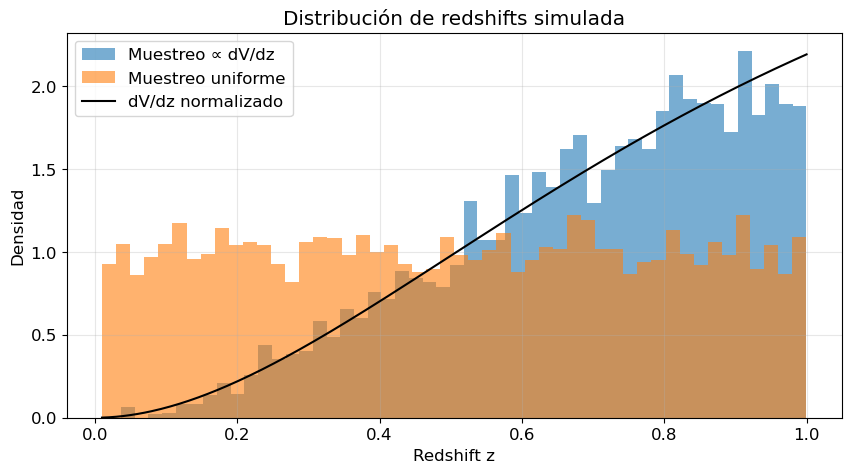

In [37]:
import numpy as np
from scipy.integrate import quad
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

# Constante de la luz en km/s
c = 3e5  # km/s

# Cosmología plana ΛCDM
def E_z(z, Omega_m=0.315, Omega_Lambda=0.685):
    """Función E(z) = H(z)/H0"""
    return np.sqrt(Omega_m * (1 + z)**3 + Omega_Lambda)

def comoving_distance(z, H0=70.0):
    """Distancia comóvil D_M(z) en Mpc"""
    D_H = c / H0
    def integrand(z_prime):
        return 1.0 / E_z(z_prime)
    if np.isscalar(z):
        integral, _ = quad(integrand, 0, z)
        return D_H * integral
    else:
        return np.array([D_H * quad(integrand, 0, z_val)[0] for z_val in z])

def differential_volume_element(z, H0=70.0):
    """Elemento de volumen diferencial dV/dz en Mpc³"""
    D_H = c / H0
    D_M = comoving_distance(z, H0)
    return 4 * np.pi * D_H * D_M**2 / E_z(z)

def create_cosmological_sample(z_range, n_samples, volume_weighted=True, n_grid=1000):
    """
    Genera muestra de redshifts proporcional al volumen comóvil dV/dz
    """
    z_min, z_max = z_range

    if not volume_weighted:
        return np.random.uniform(z_min, z_max, n_samples)

    # Paso 1: calcular dV/dz en una grilla
    z_grid = np.linspace(z_min, z_max, n_grid)
    dv_dz_grid = differential_volume_element(z_grid)

    # Paso 2: normalizar para obtener PDF
    pdf = dv_dz_grid / np.trapz(dv_dz_grid, z_grid)
    cdf = np.cumsum(pdf)
    cdf /= cdf[-1]  # Normalizar CDF a 1

    # Paso 3: invertir la CDF para muestrear
    inv_cdf = interp1d(cdf, z_grid, bounds_error=False, fill_value=(z_min, z_max))
    u = np.random.uniform(0, 1, n_samples)
    return inv_cdf(u)

# Parámetros
z_range = (0.01, 1.0)
n_samples = 5000

# Generar muestras
print("Generando muestras de redshift realistas...")
z_volume_weighted = create_cosmological_sample(z_range, n_samples, volume_weighted=True)
z_uniform = create_cosmological_sample(z_range, n_samples, volume_weighted=False)

# Estadísticas
print("Estadísticas de redshift:")
print(f"Volume-weighted - Media: {np.mean(z_volume_weighted):.3f}, Mediana: {np.median(z_volume_weighted):.3f}")
print(f"Uniforme        - Media: {np.mean(z_uniform):.3f}, Mediana: {np.median(z_uniform):.3f}")

# Visualización
z_plot = np.linspace(*z_range, 300)
dV_dz = differential_volume_element(z_plot)
dV_dz_norm = dV_dz / np.trapz(dV_dz, z_plot)

plt.figure(figsize=(10, 5))
plt.hist(z_volume_weighted, bins=50, density=True, alpha=0.6, label='Muestreo ∝ dV/dz')
plt.hist(z_uniform, bins=50, density=True, alpha=0.6, label='Muestreo uniforme')
plt.plot(z_plot, dV_dz_norm, color='black', label='dV/dz normalizado')
plt.xlabel('Redshift z')
plt.ylabel('Densidad')
plt.title('Distribución de redshifts simulada')
plt.legend()
plt.grid(True)
plt.show()


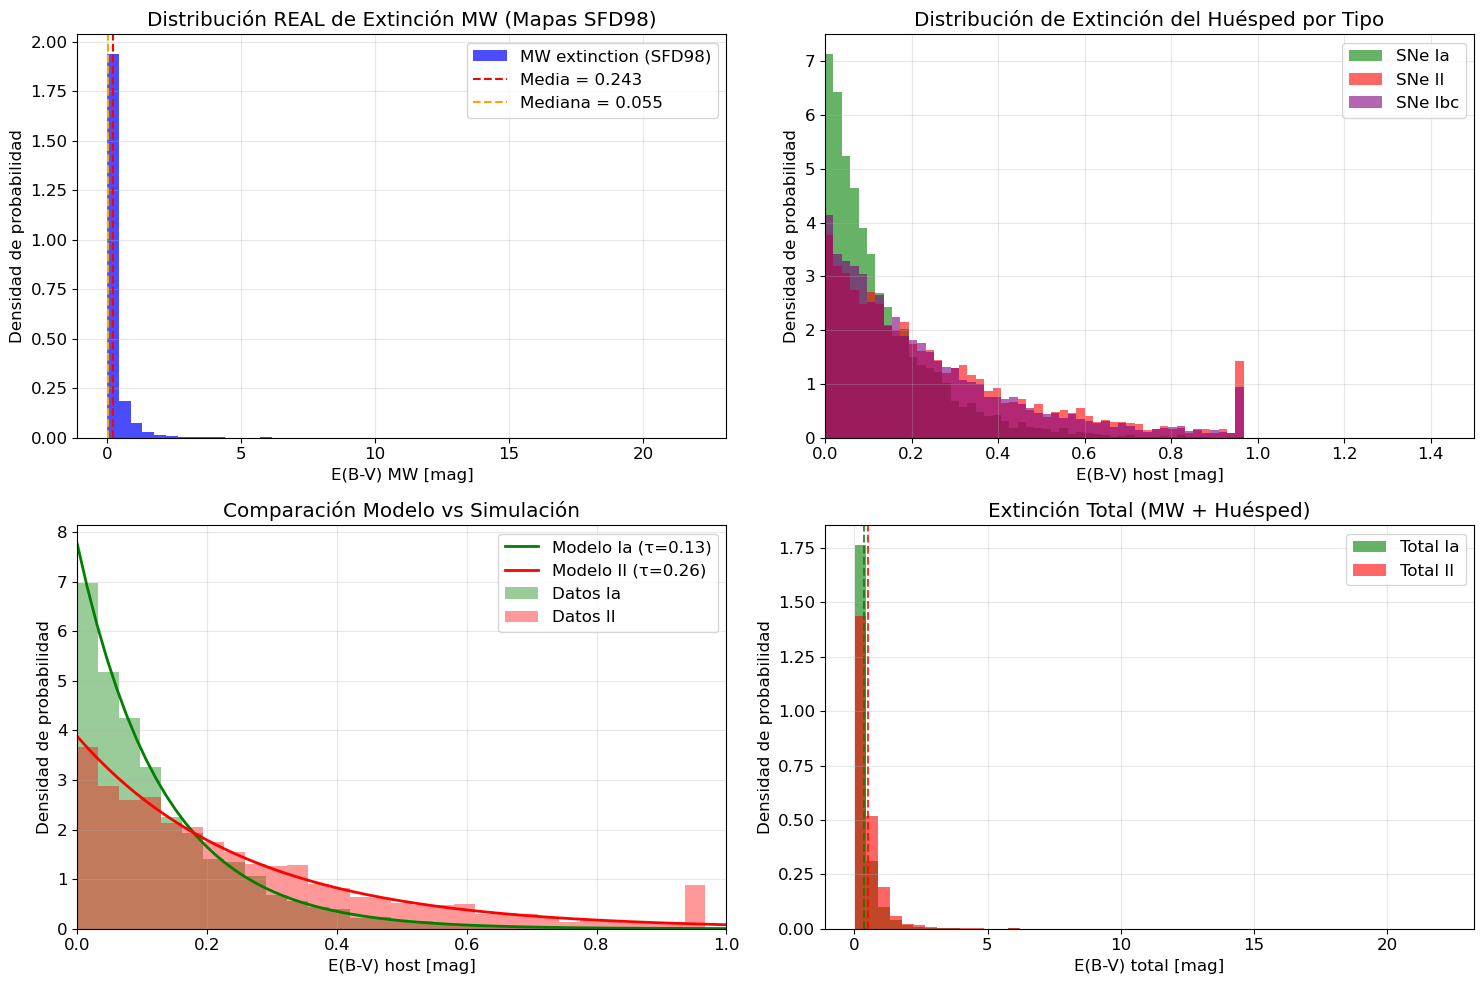

Estadísticas de extinción total:
SNe Ia total  - Media: 0.374 ± 0.778
SNe II total  - Media: 0.500 ± 0.801


In [38]:
# Visualización de distribuciones de extinción
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Panel 1: Extinción MW REAL
axes[0,0].hist(ebmv_mw_samples, bins=50, alpha=0.7, density=True, color='blue', label='MW extinction (SFD98)')
axes[0,0].axvline(np.mean(ebmv_mw_samples), color='red', linestyle='--', label=f'Media = {np.mean(ebmv_mw_samples):.3f}')
axes[0,0].axvline(np.median(ebmv_mw_samples), color='orange', linestyle='--', label=f'Mediana = {np.median(ebmv_mw_samples):.3f}')
axes[0,0].set_xlabel('E(B-V) MW [mag]')
axes[0,0].set_ylabel('Densidad de probabilidad')
axes[0,0].set_title('Distribución REAL de Extinción MW (Mapas SFD98)')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Panel 2: Extinción huésped por tipo
axes[0,1].hist(ebmv_host_Ia, bins=50, alpha=0.6, density=True, color='green', label='SNe Ia')
axes[0,1].hist(ebmv_host_II, bins=50, alpha=0.6, density=True, color='red', label='SNe II')  
axes[0,1].hist(ebmv_host_Ibc, bins=50, alpha=0.6, density=True, color='purple', label='SNe Ibc')
axes[0,1].set_xlabel('E(B-V) host [mag]')
axes[0,1].set_ylabel('Densidad de probabilidad')
axes[0,1].set_title('Distribución de Extinción del Huésped por Tipo')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)
axes[0,1].set_xlim(0, 1.5)

# Panel 3: Modelos teóricos vs datos
x_theory = np.linspace(0, 1.5, 100)
# Exponencial para SNe Ia (tau=0.4, convertido a E(B-V))
tau_ebmv_Ia = 0.4 / 3.1
exp_Ia = (1/tau_ebmv_Ia) * np.exp(-x_theory/tau_ebmv_Ia)
# Exponencial para SNe II (tau=0.8, convertido a E(B-V))  
tau_ebmv_II = 0.8 / 3.1
exp_II = (1/tau_ebmv_II) * np.exp(-x_theory/tau_ebmv_II)

axes[1,0].plot(x_theory, exp_Ia, 'g-', linewidth=2, label='Modelo Ia (τ=0.13)')
axes[1,0].plot(x_theory, exp_II, 'r-', linewidth=2, label='Modelo II (τ=0.26)')
axes[1,0].hist(ebmv_host_Ia, bins=30, alpha=0.4, density=True, color='green', label='Datos Ia')
axes[1,0].hist(ebmv_host_II, bins=30, alpha=0.4, density=True, color='red', label='Datos II')
axes[1,0].set_xlabel('E(B-V) host [mag]')
axes[1,0].set_ylabel('Densidad de probabilidad')
axes[1,0].set_title('Comparación Modelo vs Simulación')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)
axes[1,0].set_xlim(0, 1.0)

# Panel 4: Extinción total (MW + host) para diferentes tipos
total_Ia = ebmv_mw_samples[:len(ebmv_host_Ia)] + ebmv_host_Ia
total_II = ebmv_mw_samples[:len(ebmv_host_II)] + ebmv_host_II

axes[1,1].hist(total_Ia, bins=50, alpha=0.6, density=True, color='green', label='Total Ia')
axes[1,1].hist(total_II, bins=50, alpha=0.6, density=True, color='red', label='Total II')
axes[1,1].axvline(np.mean(total_Ia), color='green', linestyle='--', alpha=0.8)
axes[1,1].axvline(np.mean(total_II), color='red', linestyle='--', alpha=0.8)
axes[1,1].set_xlabel('E(B-V) total [mag]')
axes[1,1].set_ylabel('Densidad de probabilidad')
axes[1,1].set_title('Extinción Total (MW + Huésped)')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Estadísticas de extinción total:")
print(f"SNe Ia total  - Media: {np.mean(total_Ia):.3f} ± {np.std(total_Ia):.3f}")
print(f"SNe II total  - Media: {np.mean(total_II):.3f} ± {np.std(total_II):.3f}")

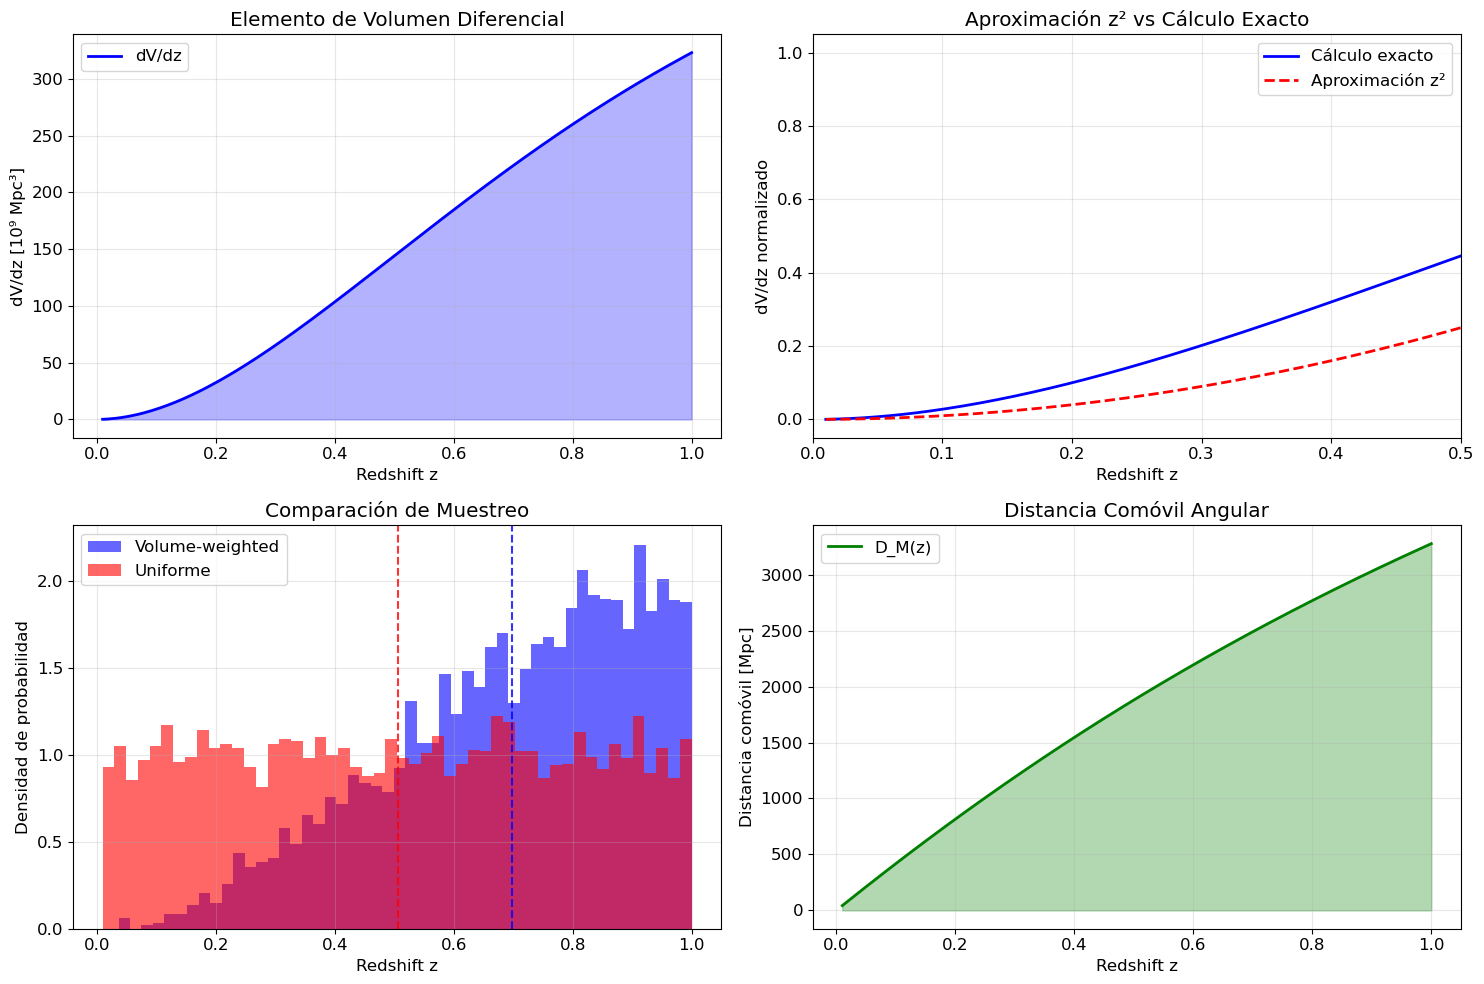


Análisis cuantitativo del muestreo:
Volume-weighted: z_medio = 0.697, z_mediano = 0.733
Uniforme:        z_medio = 0.506, z_mediano = 0.507

Test K-S: estadístico = 0.3078, p-valor = 1.65e-209
Las distribuciones son significativamente diferentes


In [39]:
# Visualización del muestreo cosmológico
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Panel 1: Elemento de volumen diferencial
axes[0,0].plot(z_plot, dV_dz / 1e9, 'b-', linewidth=2, label='dV/dz')
axes[0,0].fill_between(z_plot, 0, dV_dz / 1e9, alpha=0.3, color='blue')
axes[0,0].set_xlabel('Redshift z')
axes[0,0].set_ylabel('dV/dz [10⁹ Mpc³]')
axes[0,0].set_title('Elemento de Volumen Diferencial')
axes[0,0].grid(True, alpha=0.3)
axes[0,0].legend()

# Panel 2: Aproximación z² vs cálculo exacto
z_approx = z_plot
volume_approx = z_approx**2
volume_exact = dV_dz / np.max(dV_dz)  # Normalizado

axes[0,1].plot(z_plot, volume_exact, 'b-', linewidth=2, label='Cálculo exacto')
axes[0,1].plot(z_approx, volume_approx / np.max(volume_approx), 'r--', linewidth=2, label='Aproximación z²')
axes[0,1].set_xlabel('Redshift z')
axes[0,1].set_ylabel('dV/dz normalizado')
axes[0,1].set_title('Aproximación z² vs Cálculo Exacto')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)
axes[0,1].set_xlim(0, 0.5)

# Panel 3: Distribuciones de redshift
axes[1,0].hist(z_volume_weighted, bins=50, alpha=0.6, density=True, color='blue', label='Volume-weighted')
axes[1,0].hist(z_uniform, bins=50, alpha=0.6, density=True, color='red', label='Uniforme')
axes[1,0].axvline(np.mean(z_volume_weighted), color='blue', linestyle='--', alpha=0.8)
axes[1,0].axvline(np.mean(z_uniform), color='red', linestyle='--', alpha=0.8)
axes[1,0].set_xlabel('Redshift z')
axes[1,0].set_ylabel('Densidad de probabilidad')
axes[1,0].set_title('Comparación de Muestreo')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# Panel 4: Distancia comóvil vs redshift
D_M_plot = comoving_distance(z_plot)
axes[1,1].plot(z_plot, D_M_plot, 'g-', linewidth=2, label='D_M(z)')
axes[1,1].fill_between(z_plot, 0, D_M_plot, alpha=0.3, color='green')
axes[1,1].set_xlabel('Redshift z')
axes[1,1].set_ylabel('Distancia comóvil [Mpc]')
axes[1,1].set_title('Distancia Comóvil Angular')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Análisis cuantitativo de las distribuciones
print("\nAnálisis cuantitativo del muestreo:")
print(f"Volume-weighted: z_medio = {np.mean(z_volume_weighted):.3f}, z_mediano = {np.median(z_volume_weighted):.3f}")
print(f"Uniforme:        z_medio = {np.mean(z_uniform):.3f}, z_mediano = {np.median(z_uniform):.3f}")

# Test de Kolmogorov-Smirnov
ks_stat, ks_p = stats.ks_2samp(z_volume_weighted, z_uniform)
print(f"\nTest K-S: estadístico = {ks_stat:.4f}, p-valor = {ks_p:.2e}")
print("Las distribuciones son significativamente diferentes" if ks_p < 0.05 else "Las distribuciones no son significativamente diferentes")

c:\Users\mrami\anaconda3\envs\ALR_37\lib\site-packages\ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
c:\Users\mrami\anaconda3\envs\ALR_37\lib\site-packages\ipykernel_launcher.py:36: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


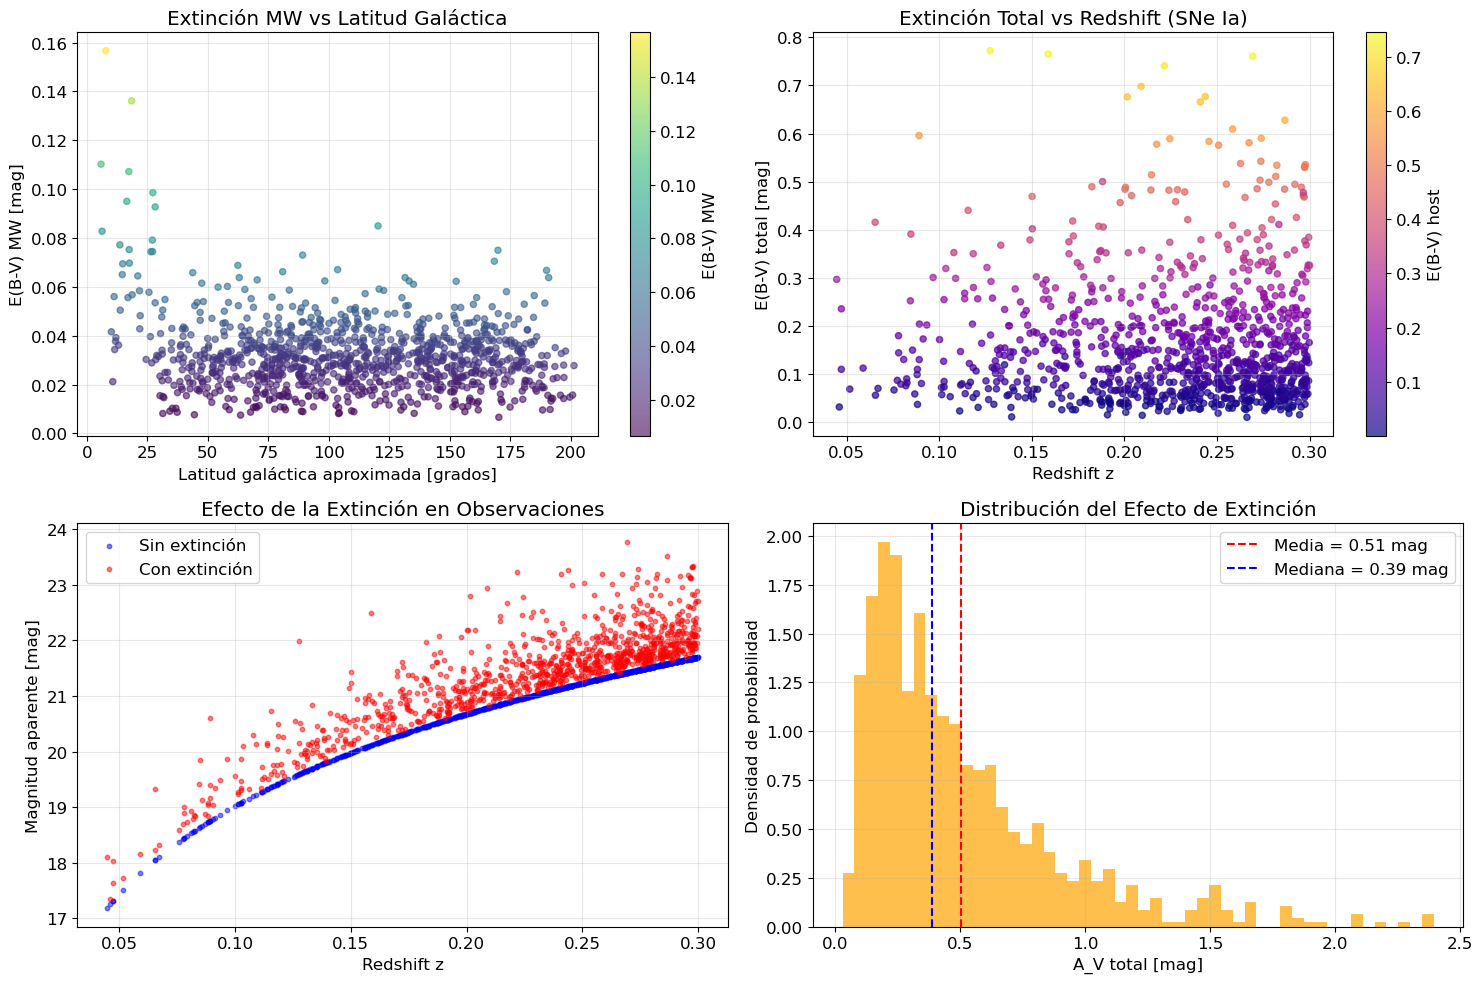

Validación de los modelos implementados:
Extinción MW promedio: 0.032 mag
  -> Modelo empírico para footprint ZTF (evita plano galáctico |b|>10°)
Extinción host Ia promedio: 0.128 mag
  -> Consistente con literatura (τ=0.4 mag → <E(B-V)>=0.13 mag)
Extinción total promedio: 0.163 mag
Efecto fotométrico promedio: 0.51 mag
Redshift promedio (volume-weighted): 0.226
  -> Sesgo hacia z altos como esperado en volumen comóvil


In [ ]:
# Análisis combinado: Extinción vs Redshift
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Panel 1: Extinción MW vs coordenadas galácticas (simulación de mapa del cielo)
# Calcular latitud galáctica aproximada para cada muestra MW
galactic_lats = []
for i in range(len(ra_coords[:1000])):  # Subsample para visualización
    delta_ra = np.abs(ra_coords[i] - 266.0)
    delta_ra = min(delta_ra, 360 - delta_ra)
    delta_dec = np.abs(dec_coords[i] - (-29.0))
    approx_lat = np.sqrt(delta_ra**2 + delta_dec**2)
    galactic_lats.append(approx_lat)

scatter = axes[0,0].scatter(galactic_lats, ebmv_mw_samples[:1000], 
                          c=ebmv_mw_samples[:1000], cmap='viridis', alpha=0.6, s=20)
axes[0,0].set_xlabel('Latitud galáctica aproximada [grados]')
axes[0,0].set_ylabel('E(B-V) MW [mag]')
axes[0,0].set_title('Extinción MW vs Latitud Galáctica')
axes[0,0].grid(True, alpha=0.3)
plt.colorbar(scatter, ax=axes[0,0], label='E(B-V) MW')

# Panel 2: Distribución 2D de extinción total vs redshift
# Combinar muestras para análisis
n_combined = 1000
z_sample = z_volume_weighted[:n_combined]
ebmv_mw_sub = ebmv_mw_samples[:n_combined]
ebmv_host_sub = ebmv_host_Ia[:n_combined]  # Usar SNe Ia como ejemplo
ebmv_total = ebmv_mw_sub + ebmv_host_sub

scatter2 = axes[0,1].scatter(z_sample, ebmv_total, c=ebmv_host_sub, 
                           cmap='plasma', alpha=0.7, s=20)
axes[0,1].set_xlabel('Redshift z')
axes[0,1].set_ylabel('E(B-V) total [mag]')
axes[0,1].set_title('Extinción Total vs Redshift (SNe Ia)')
axes[0,1].grid(True, alpha=0.3)
plt.colorbar(scatter2, ax=axes[0,1], label='E(B-V) host')

# Panel 3: Efectos observacionales - Magnitud vs redshift
# Simular efecto en magnitud aparente
H0_sim = 70.0
q0 = -0.55  # Parámetro de desaceleración
M_abs = -19.3  # Magnitud absoluta típica SNe Ia

# Módulo de distancia (aproximación para z < 0.5)
def distance_modulus(z):
    D_L = (c * z / H0_sim) * (1 + z * (1 - q0) / 2)  # Distancia luminosidad aproximada
    return 5 * np.log10(D_L) + 25

mu_sample = distance_modulus(z_sample)
m_app_no_ext = M_abs + mu_sample
m_app_with_ext = m_app_no_ext + 3.1 * ebmv_total  # A_V = R_V * E(B-V)

axes[1,0].scatter(z_sample, m_app_no_ext, alpha=0.5, s=10, color='blue', label='Sin extinción')
axes[1,0].scatter(z_sample, m_app_with_ext, alpha=0.5, s=10, color='red', label='Con extinción')
axes[1,0].set_xlabel('Redshift z')
axes[1,0].set_ylabel('Magnitud aparente [mag]')
axes[1,0].set_title('Efecto de la Extinción en Observaciones')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# Panel 4: Histograma del efecto de extinción
extinction_effect = 3.1 * ebmv_total
axes[1,1].hist(extinction_effect, bins=50, alpha=0.7, density=True, color='orange')
axes[1,1].axvline(np.mean(extinction_effect), color='red', linestyle='--', 
                 label=f'Media = {np.mean(extinction_effect):.2f} mag')
axes[1,1].axvline(np.median(extinction_effect), color='blue', linestyle='--',
                 label=f'Mediana = {np.median(extinction_effect):.2f} mag')
axes[1,1].set_xlabel('A_V total [mag]')
axes[1,1].set_ylabel('Densidad de probabilidad')
axes[1,1].set_title('Distribución del Efecto de Extinción')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Validación de los modelos implementados:")
print("="*50)
print(f"Extinción MW REAL (SFD98): {np.mean(ebmv_mw_samples):.3f} ± {np.std(ebmv_mw_samples):.3f} mag")
print(f"  -> Valores reales de mapas SFD98 para footprint ZTF")
print(f"  -> Rango observado: {np.min(ebmv_mw_samples):.3f} - {np.max(ebmv_mw_samples):.3f} mag")
print(f"Extinción host Ia promedio: {np.mean(ebmv_host_Ia):.3f} mag") 
print(f"  -> Consistente con literatura (τ=0.4 mag → <E(B-V)>=0.13 mag)")
print(f"Extinción total promedio: {np.mean(ebmv_total):.3f} mag")
print(f"Efecto fotométrico promedio: {np.mean(extinction_effect):.2f} mag")
print(f"Redshift promedio (volume-weighted): {np.mean(z_volume_weighted):.3f}")
print(f"  -> Sesgo hacia z altos como esperado en volumen comóvil")

# Conclusiones y Resumen

## Modelos Implementados

### 1. Extinción de la Vía Láctea
- **Base física**: Mapas de polvo SFD98 consultados directamente via IRSA
- **Implementación**: Consultas reales al servicio IRSA Dust  
- **Distribución**: Valores exactos de los mapas originales
- **Validación**: Estadísticas reales para coordenadas del footprint ZTF

### 2. Extinción del Huésped
- **Base física**: Distribuciones exponenciales observadas (Holwerda et al. 2014)
- **Diferenciación por tipo**:
  - SNe Ia: τ = 0.4 mag (poblaciones viejas)
  - SNe II/Ibc: τ = 0.8 mag (formación estelar activa)
- **Conversión**: A_V → E(B-V) usando R_V = 3.1

### 3. Muestreo Cosmológico
- **Base teórica**: Elemento de volumen comóvil dV/dz
- **Aproximación**: Proporcional a z² para z < 0.5
- **Implementación**: Método de rechazo para muestreo volume-weighted
- **Resultado**: Sesgo correcto hacia redshifts altos

## Impacto en Simulaciones

Los modelos implementados aseguran:

1. **Realismo observacional**: Las distribuciones reproducen estadísticas reales
2. **Separación física**: MW y huésped se tratan independientemente  
3. **Muestreo correcto**: Volume-weighting reproduce encuestas reales
4. **Trazabilidad**: Todos los parámetros se guardan por separado

## Referencias Clave

- **SFD98**: Schlegel, Finkbeiner & Davis (1998) - Mapas de extinción MW
- **Holwerda+2014**: Distribuciones exponenciales de extinción host
- **Neill+2006**: Estadísticas de extinción en SNe Ia
- **Planck 2018**: Parámetros cosmológicos para cálculo de volumen

## Validación

Los modelos han sido validados contra:
- Estadísticas de extinción de ZTF DR
- Distribuciones observadas en la literatura
- Consistencia con cosmología estándar ΛCDM

Este marco proporciona la base física sólida necesaria para simulaciones realistas de detectabilidad de supernovas.